In [2]:
import sys
sys.path.append('../')
import face_mask
import torch
from torch import nn
import torchvision

In [3]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels,
                             kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)

In [4]:
def backbone():
    blk = []
    filters = [3, 16, 32, 64]
    for i in range(len(filters) - 1):
        blk.append(down_sample_blk(filters[i], filters[i + 1]))
    return nn.Sequential(*blk)

In [5]:
def default_anchors(fmap, scales, ratios):
    # generate `bbox` for per pixel.
    pair = [(scales[0], ratio) for ratio in ratios]
    pair += [(scale, ratios[0]) for scale in scales[1:]]
    pair = torch.tensor(pair)
    (h, w) = fmap.shape[-2:]
    # shift per pixel to center
    offset = .5
    step_h, step_w = 1. / h, 1. / w
    all_w, all_h = (torch.arange(w, dtype=torch.float32) + offset) * step_w, (
        torch.arange(h, dtype=torch.float32) + offset) * step_h
    pixel_x, pixel_y = torch.meshgrid(all_w, all_h)
    all = []
    for (scale, ratio) in pair:
        half_bw = w / h * scale * torch.sqrt(ratio) / 2
        half_bh = scale / torch.sqrt(ratio) / 2
        xmin = pixel_x - half_bw
        ymin = pixel_y - half_bh
        xmax = pixel_x + half_bw
        ymax = pixel_y + half_bh
        box = torch.stack((xmin, ymin, xmax, ymax), dim=-1)
        all.append(box)
    all = torch.stack(all)
    return torch.reshape(all, (-1, 4))

/home/fyang/.conda/envs/mlenv/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


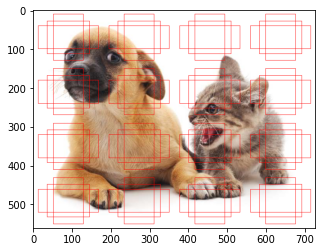

In [6]:
from PIL import Image
img = Image.open('./catdog.jpg').convert('RGB')
img = torchvision.transforms.ToTensor()(img)
fmap = torch.zeros((1, 16, 4, 4))
anchors = default_anchors(fmap, [.15], [1, 2, .5])
anchors[:, ::2] = anchors[:, ::2] * img.shape[-1]
anchors[:, 1::2] = anchors[:, 1::2] * img.shape[-2]
img *= 255
img = img.to(dtype=torch.uint8)
img_1 = torchvision.utils.draw_bounding_boxes(img, boxes=anchors, colors='red').permute(1,2,0)
from matplotlib import pyplot as plt
plt.imshow(img_1)

In [7]:
def box_iou(anchors, bboxes):
    # xmin ymin xmax ymax
    a_area = (anchors[:, 2] - anchors[:, 0]) * (anchors[:, 3] - anchors[:, 1])
    b_area = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    inter_xy_min = torch.maximum(anchors[:, None, :2], bboxes[:, :2])
    inter_xy_max = torch.minimum(anchors[:, None, 2:], bboxes[:, 2:])
    inters = torch.clip(inter_xy_max - inter_xy_min, 0)
    inter_area = inters[:, :, 0] * inters[:, :, 1]
    union_area = a_area[:, None] + b_area - inter_area
    return inter_area / union_area

In [8]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])
box_iou(anchors=anchors, bboxes=ground_truth[:, 1:])

tensor([[0.0536, 0.0000],
        [0.1417, 0.0000],
        [0.0000, 0.5657],
        [0.0000, 0.2059],
        [0.0000, 0.7459]])

In [21]:
def labeling_anchors(anchors, bboxes, threshold=.5):
    iou = box_iou(anchors, bboxes)
    # i-anchor j-bbox
    n_anchor, n_bbox = iou.shape
    row_discard = torch.zeros((n_bbox, ))
    col_discard = torch.zeros((n_anchor, ))
    anchor_bbox_map = torch.full((n_anchor, ), fill_value=-1)
    for i in range(n_bbox):
        maximum_idx = iou.argmax()
        maximum_i = torch.floor(maximum_idx / n_bbox).to(dtype=torch.int32)
        maximum_j = (maximum_idx % n_bbox).to(dtype=torch.int32)
        maximum = iou[maximum_i, maximum_j]
        if maximum < threshold:
            break
        anchor_bbox_map[maximum_i] = maximum_j
        iou[maximum_i, :] = row_discard
        iou[:, maximum_j] = col_discard
    return anchor_bbox_map
    

In [22]:
labeling_anchors(anchors, ground_truth[:, 1:], threshold=.1)

tensor([-1,  0, -1, -1,  1])

In [48]:
def corner_to_center(box):
    """
        xyxy to xywh
    """
    cw, ch = (box[:, 0] + box[:, 2]) / 2, (box[:, 1] + box[:, 3]) / 2
    w, h = box[:, 2] - box[:, 0], box[:, 3] - box[:, 1]
    return torch.stack((cw, ch, w, h), axis=-1)


def center_to_corner(box):
    """
        xywh to xyxy
    """
    half_w, half_h = box[:, 2] / 2., box[:, 3] / 2.
    return torch.stack((box[:, 0] - half_w, box[:, 0] + half_w,
                      box[:, 1] - half_h, box[:, 1] + half_h),
                     axis=-1)

def offset_boxes(anchors, bboxes, eps=1e-6):
    centered_anchors = corner_to_center(anchors)
    centered_bboxes = corner_to_center(bboxes)
    offset_xy = 10 * (centered_bboxes[:, :2] - centered_anchors[:, :2]) / centered_anchors[:, 2:]
    offset_wh = 5 * torch.log(eps + centered_bboxes[:, 2:]) / centered_anchors[:, 2:]
    return torch.cat([offset_xy, offset_wh], dim=1)

def offset_inverse(anchors, offsets):
    centered_anchors = corner_to_center(anchors)
    bbox_xy = (offsets[:, :2] * centered_anchors[:, 2:] / 10) + centered_anchors[:, :2]
    bbox_wh = torch.exp(offsets[:, 2:] / 5) * centered_anchors[:, 2:]
    bboxes = torch.cat((bbox_xy, bbox_wh), dim=1)
    return center_to_corner(bboxes)


In [45]:
def matching(anchors, target, threshold=.5):
    labels, bboxes = target['labels'], target['boxes']
    anchor_bbox_map = labeling_anchors(anchors, bboxes, threshold=threshold)
    matched_anchor_indicates = torch.nonzero(anchor_bbox_map >= 0).view(-1)
    matched_bbox_indicates = anchor_bbox_map[matched_anchor_indicates].view(-1)
    matched_labels = labels[matched_bbox_indicates]
    matched_bboxes = bboxes[matched_bbox_indicates]
    matched_anchors = anchors[matched_anchor_indicates]
    offsets = offset_boxes(matched_anchors, matched_bboxes)
    return matched_anchor_indicates, offsets, matched_labels

In [47]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
target = {
    'labels': torch.tensor([1, 2]),
    'boxes': torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.55, 0.2, 0.9, 0.88]])
    
}
matching(anchors=anchors, target=target, threshold=.5)

(tensor([4]), tensor([[ -0.5714,  -1.0000, -14.9974,  -3.2138]]), tensor([2]))

In [ ]:
def cls_predictor(in_filters, n_anchors, n_classes):
    return nn.Conv2d(in_filters,
                     n_anchors * (n_classes + 1),
                     kernel_size=3,
                     padding=1)


def bbox_predictor(in_filters, n_anchors):
    return nn.Conv2d(in_filters, n_anchors * 4, kernel_size=3, padding=1)


class SSD(nn.Module):
    def __init__(self, n_classes, **kwargs):
        super(SSD, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
                      [0.88, 0.961]]
        self.ratios = [1, 2, 0.5]
        n_anchors = len(self.sizes[0]) + len(self.ratios) - 1
        self.extractors = [
            (backbone(), cls_predictor(64, n_anchors, n_classes),
             bbox_predictor(64, n_anchors)),
            (down_sample_blk(64, 128), cls_predictor(128, n_anchors,
                                                     n_classes),
             bbox_predictor(128, n_anchors)),
            (down_sample_blk(128, 128), cls_predictor(128, n_anchors,
                                                      n_classes),
             bbox_predictor(128, n_anchors)),
            (down_sample_blk(128, 128), cls_predictor(128, n_anchors,
                                                      n_classes),
             bbox_predictor(128, n_anchors)),
            (nn.AdaptiveMaxPool2d(
                (1, 1)), cls_predictor(128, n_anchors, n_classes),
             bbox_predictor(128, n_anchors))
        ]
    
    def forward(self, x, y):
        _len = len(self.extractors)
        anchors, cls_preds, bbox_preds = [None] * _len, [None] * _len, [None] * _len
        for (i, (extractor, cls_pred_net, bbox_pred_net)) in enumerate(self.extractors):
            x = extractor(x)
            anchors[i] = default_anchors(x, self.sizes[i], self.ratios)
            cls_preds[i] = cls_pred_net(x)
            bbox_preds[i] = bbox_pred_net(x)
        return torch.cat(anchors, dim=1)
        